# Project 2: Moving Average Crossover Backtester

## Overview

In this project, I am building a simple backtesting framework to test a classic technical trading strategy: the moving average crossover. The idea is to use a fast-moving average and a slow-moving average to identify trends in asset prices. When the fast MA rises above the slow MA, the strategy goes long; otherwise, it stays out of the market.

---

## Features

- Loading and preparing price data with yfinance
- Generating trading signals from moving average crossovers
- Translating signals into positions and computing returns
- Accounting for simple transaction costs
- Comparing strategy performance against buy-and-hold
- Evaluating performance using annualised return, volatility, Sharpe ratio, and max drawdown
- Exploring how results vary across different fast/slow MA combinations

---

I will start by reading prices for MSFT, TSLA, and NVDA and defining the idea. A moving average crossover tries to catch trends, where a fast MA follows price closely and a slow MA is smoother.

When fast > slow there is an uptrend so we go long; otherwise we don't trade or short. Signals will be generated where +1 means long, -1 short, and 0 flat. 

To avoid look ahead bias, we shift the signal by one day as today's trade must be based on information available at yesterday's close.

Once the signals have been turned into positions, we can calculate the returns and add transaction costs (1% assumed).

In [51]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

TICKERS = "MSFT", "TSLA", "NVDA"
PERIOD = "3y"

px = yf.download(TICKERS, period=PERIOD, interval="1d", auto_adjust=True, progress=False)["Close"]
px = px.ffill().dropna()

fast = 10
slow = 120

ma_fast = px.rolling(fast, min_periods=fast).mean()
ma_slow = px.rolling(slow, min_periods=slow).mean()

signal = np.where(ma_fast > ma_slow, 1.0, np.where(ma_fast < ma_slow, -1.0, 0.0))
signal = pd.DataFrame(signal, index=px.index, columns=px.columns)

positions = pd.DataFrame(index=px.index, columns=px.columns)
positions_exec = signal.shift(1).fillna(0.0)

rets = px.pct_change().fillna(0.0)
per_asset_pnl = positions_exec * rets
gross = per_asset_pnl.mean(axis=1)

bps_cost = 0.01

turnover = positions_exec.diff().abs().mean(axis=1).fillna(0.0)
costs = turnover * bps_cost
net = gross - costs

---

Now we want to turn returns into equity curves to show compounding and provide metrics that summarise performance and risk

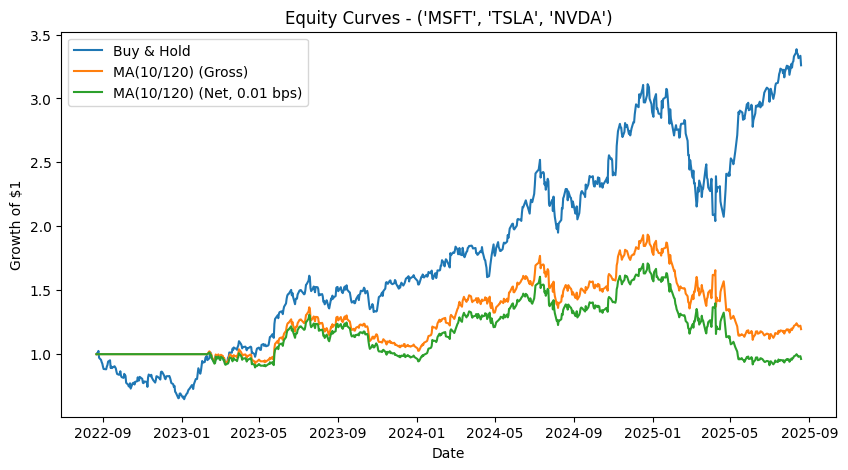

{'Ann.Return': np.float64(-0.012699846984748908),
 'Ann.Vol': np.float64(0.3103062582254492),
 'Sharpe': np.float64(-0.040926815518886474),
 'Max.DD': np.float64(-0.46582899903439035),
 'Avg.Turnover': np.float64(0.028850421660008875)}

In [52]:
buyhold = (1 + rets.mean(axis=1)).cumprod()
eq_gross = (1 + gross).cumprod()
eq_et = (1 + net).cumprod()

plt.figure(figsize=(10, 5))
plt.plot(buyhold.index, buyhold, label="Buy & Hold")
plt.plot(eq_gross.index, eq_gross, label=f"MA({fast}/{slow}) (Gross)")
plt.plot(eq_et.index, eq_et, label=f"MA({fast}/{slow}) (Net, {bps_cost} bps)")
plt.title(f"Equity Curves - {TICKERS}")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.show()

def ann_return(daily_rets: pd.Series) -> float:
    n = daily_rets.shape[0]
    if n == 0: return np.nan
    return (1 + daily_rets).prod() ** (252 / n) - 1

def ann_vol(daily_rets:pd.Series) -> float:
    return daily_rets.std() * np.sqrt(252)

def sharpe(daily_rets: pd.Series) -> float:
    vol = ann_vol(daily_rets)
    return np.nan if vol == 0 or np.isnan(vol) else ann_return(daily_rets) / vol

def max_drawdown(equity: pd.Series) -> float:
    roll_max = equity.cummax()
    dd = equity / roll_max - 1
    return dd.min()

eq = (1 + net).cumprod()

metrics = {
    "Ann.Return": ann_return(net),
    "Ann.Vol": ann_vol(net),
    "Sharpe": sharpe(net),
    "Max.DD": max_drawdown(eq),
    "Avg.Turnover": turnover.mean(),
}

metrics